In [25]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import eig
import sympy.physics.mechanics as me
from sympy.physics.vector.printing import vpprint, vlatex
from sympy.utilities.codegen import codegen
from sympy.utilities.autowrap import autowrap
from dataclasses import dataclass, InitVar, field
from sympy.abc import x,y,z,t

from FwtModels import AssumedShapes

Aiming to calculate the K.E of the non-linear FWTD

first just to get my head around things i will consider a device with 2 DoF's d (hinge plunge) and theta (hinge angle - assuming it is in the y-z plane)

the FWT has a mass of m, located s_t away from the hinge

In [86]:
## Create some variables
s_t,m_t = sym.symbols(['s_t','m_t'])
theta,d = me.dynamicsymbols(['theta','d'])

q = sym.Matrix([theta,d])
qd = q.diff(t)

In [87]:
# create Homogenous transform matrix from a/c to the hinge
H = sym.rot_axis3(theta)
H[1,2] = d
H

⎡cos(θ)   sin(θ)  0⎤
⎢                  ⎥
⎢-sin(θ)  cos(θ)  d⎥
⎢                  ⎥
⎣   0       0     1⎦

In [88]:
# calculate the jacobian (needs to also include rotational terms)
J=sym.zeros(3,2)


Jp = (H*sym.Matrix([s_t,0,1])).jacobian(q)
J[:2,:] = Jp[:2,:]

J[2,:] = sym.Matrix([theta]).jacobian(q)
J

⎡-sₜ⋅sin(θ)  0⎤
⎢             ⎥
⎢-sₜ⋅cos(θ)  1⎥
⎢             ⎥
⎣    1       0⎦

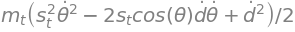

In [90]:
# Calculate the K.E
M = sym.diag(m_t,m_t,0)
Mq = sym.simplify(J.T*M*J)
sym.simplify(sym.Rational(1,2)*qd.T*Mq*qd)[0]

This matchs the analytical answer so thats a good start!

Now lets generalise this into both 3D and add the fact the hinge angle is not zero

In [92]:
## Create some variables
s_t,m_t,Lambda = sym.symbols(['s_t','m_t','Lambda'])
theta,d = me.dynamicsymbols(['theta','d'])

q = sym.Matrix([theta,d])
qd = q.diff(t)

# create Homogenous transform matrix from a/c to the hinge
R = sym.simplify(sym.rot_axis3(Lambda)*sym.rot_axis1(theta)*sym.rot_axis3(-Lambda))

T = sym.eye(4)
T[:3,:3] = R
T[2,3] = d
T

⎡    2                2                                                  ⎤
⎢ sin (Λ)⋅cos(θ) + cos (Λ)   (cos(θ) - 1)⋅sin(Λ)⋅cos(Λ)  sin(Λ)⋅sin(θ)  0⎥
⎢                                                                        ⎥
⎢                                2         2                             ⎥
⎢(cos(θ) - 1)⋅sin(Λ)⋅cos(Λ)   sin (Λ) + cos (Λ)⋅cos(θ)   sin(θ)⋅cos(Λ)  0⎥
⎢                                                                        ⎥
⎢      -sin(Λ)⋅sin(θ)              -sin(θ)⋅cos(Λ)           cos(θ)      d⎥
⎢                                                                        ⎥
⎣            0                           0                     0        1⎦

In [94]:
# calculate the jacobian (needs to also include rotational terms)
J=sym.zeros(6,len(q))

Jp = (T*sym.Matrix([0,s_t,0,1])).jacobian(q)
J[:3,:] = Jp[:3,:]

J[3:,:] = sym.Matrix([theta,0,0]).jacobian(q)
J

⎡-sₜ⋅sin(Λ)⋅sin(θ)⋅cos(Λ)  0⎤
⎢                           ⎥
⎢                 2         ⎥
⎢   -sₜ⋅sin(θ)⋅cos (Λ)     0⎥
⎢                           ⎥
⎢   -sₜ⋅cos(Λ)⋅cos(θ)      1⎥
⎢                           ⎥
⎢           1              0⎥
⎢                           ⎥
⎢           0              0⎥
⎢                           ⎥
⎣           0              0⎦

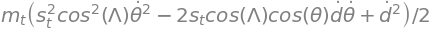

In [97]:
# Calculate the K.E
M = sym.diag(m_t,m_t,m_t,0,0,0)
Mq = sym.simplify(J.T*M*J)
sym.simplify(sym.Rational(1,2)*qd.T*Mq*qd)[0]

Nothing too crazy here yet.... now lets add two other DoF:

twist at the hinge about x and y prior to the hinge transform 


In [98]:
## Create some variables
s_t,m_t,Lambda = sym.symbols(['s_t','m_t','Lambda'])
theta,z_w,alpha_w,z_wa = me.dynamicsymbols(['theta','z_w','alpha_w','z_wa'])

q = sym.Matrix([theta,d,alpha_w,z_wa])
qd = q.diff(t)

# create Homogenous transform matrix from a/c to the hinge
R = sym.simplify(sym.rot_axis2(alpha_w)*sym.rot_axis1(z_wa)*sym.rot_axis3(Lambda)*sym.rot_axis1(theta)*sym.rot_axis3(-Lambda))

T = sym.eye(4)
T[:3,:3] = R
T[2,3] = d
T

⎡((sin(Λ)⋅cos(α_w) + sin(α_w)⋅sin(z_wa)⋅cos(Λ))⋅cos(θ) + sin(α_w)⋅sin(θ)⋅cos(z
⎢                                                                             
⎢                                                                             
⎢                                    (-sin(θ)⋅sin(z_wa) + cos(Λ)⋅cos(θ)⋅cos(z_
⎢                                                                             
⎢((sin(Λ)⋅sin(α_w) - sin(z_wa)⋅cos(Λ)⋅cos(α_w))⋅cos(θ) - sin(θ)⋅cos(α_w)⋅cos(z
⎢                                                                             
⎣                                                                       0     

_wa))⋅sin(Λ) - (sin(Λ)⋅sin(α_w)⋅sin(z_wa) - cos(Λ)⋅cos(α_w))⋅cos(Λ)  ((sin(Λ)⋅
                                                                              
                                                                              
wa) - cos(Λ)⋅cos(z_wa))⋅sin(Λ)                                                
                                                   

In [99]:
# calculate the jacobian (needs to also include rotational terms)
J=sym.zeros(6,len(q))

Jp = (T*sym.Matrix([0,s_t,0,1])).jacobian(q)
J[:3,:] = Jp[:3,:]

J[3:,:] = sym.Matrix([theta,0,0]).jacobian(q)
J

⎡                                                                             
⎢sₜ⋅(-(sin(Λ)⋅cos(α_w) + sin(α_w)⋅sin(z_wa)⋅cos(Λ))⋅sin(θ) + sin(α_w)⋅cos(θ)⋅c
⎢                                                                             
⎢                                                                             
⎢                   sₜ⋅(-sin(θ)⋅cos(Λ)⋅cos(z_wa) - sin(z_wa)⋅cos(θ))⋅cos(Λ)   
⎢                                                                             
⎢                                                                             
⎢sₜ⋅(-(sin(Λ)⋅sin(α_w) - sin(z_wa)⋅cos(Λ)⋅cos(α_w))⋅sin(θ) - cos(α_w)⋅cos(θ)⋅c
⎢                                                                             
⎢                                              1                              
⎢                                                                             
⎢                                              0                              
⎢                                                   

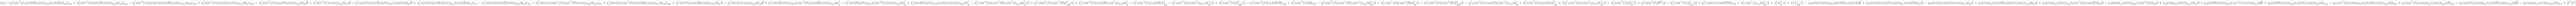

In [100]:
# Calculate the K.E
M = sym.diag(m_t,m_t,m_t,0,0,0)
Mq = sym.simplify(J.T*M*J)
sym.simplify(sym.Rational(1,2)*qd.T*Mq*qd)[0]

With the shape functions I normally use?

In [110]:
semiSpan = 1.345  # semi-span of the wing
ratioFwt = 0.29   # ratio of the wing semi span that is fwt
chord = 0.15
FwtMassPerUnitArea = 0.597/(semiSpan*ratioFwt*chord)

# with width b and hieght h
h = 0.005 # hieght of bar
b = 0.03 # width of bar
I_xx = b*h**3/12
I_yy = b**3*h/12
J = I_xx + I_yy



# Material properties
E = 190e9
G = 74e9
Density = 8000

WingMassPerUnitArea = 8000*h*b/chord # convert to uniform mass over a chord 

# create an instance of the class holding all the properties for the FWT
p = AssumedShapes.FwtParameters(m_w = WingMassPerUnitArea,
                        m_t = FwtMassPerUnitArea,
                        x_f = 0.25,
                        s_w = semiSpan*(1-ratioFwt),
                        s_t = semiSpan*ratioFwt,
                        c = chord,
                        Lambda = np.deg2rad(10),
                        EI = E*I_xx,
                        GJ = G*J,
                        k_theta = 0,
                        rho = 1.225,
                        V = 10,
                        a_w = 2*np.pi,
                        a_t = 2*np.pi,
                        alpha_0 = 0,
                        e = 0.25,
                        Malphadot = -1.2,
                        g = 9.81)

In [111]:
## Define number of shapes
Bterms = 1
Tterms = 1
thetaTerms = 1

coords = Bterms+Tterms+thetaTerms

## create generalised coordinates
qList = me.dynamicsymbols(f'q:{coords-1}')
theta = me.dynamicsymbols('theta')
qList.append(theta)

q = sym.Matrix(qList)

qd = q.diff(t)
qdd = qd.diff(t)

## create wing shape
z_w = sym.Integer(0)
alpha_w = sym.Integer(0)

for i in range(0,Bterms):
    z_w = z_w + q[i]*y**(i+2)
for i in range(0,Tterms):
    ind = i + (Bterms-1)
    z_w = z_w + q[ind]*(x-p.x_f)*y**(i+1)
    alpha_w = alpha_w + q[ind]*y**(i+1)

kappa_w = z_w.subs(x,p.x_f)

## create FWT shape
# as we need to account for tip shortening effects these are defined in the FWT reference frame
# we include the twist due to the end of the wing in this refernce frame as well
alpha_h = sym.Function('alpha_h')(theta)

alpha_t = alpha_h +  
z_t = alpha_t*(x-p.x_f)


In [113]:
# create Homogenous transform matrix from a/c to the hinge
R = sym.simplify(sym.rot_axis2(alpha_w.subs(y,s_w))*sym.rot_axis1(kappa_w.subs(y,p.s_w))*sym.rot_axis3(p.Lambda)*sym.rot_axis1(theta)*sym.rot_axis3(-p.Lambda))

T = sym.eye(4)
T[:3,:3] = R
T[2,3] = d
T

⎡⎛⎛                        ⎛   2   ⎞                   ⎞                      
⎢⎝⎝sin(Λ)⋅cos(s_w⋅q₀) + sin⎝s_w ⋅q₀⎠⋅sin(s_w⋅q₀)⋅cos(Λ)⎠⋅cos(θ) + sin(s_w⋅q₀)⋅
⎢                                                                             
⎢                                           ⎛     ⎛   2   ⎞                   
⎢                                           ⎝- sin⎝s_w ⋅q₀⎠⋅sin(θ) + cos(Λ)⋅co
⎢                                                                             
⎢⎛⎛                        ⎛   2   ⎞                   ⎞                    ⎛ 
⎢⎝⎝sin(Λ)⋅sin(s_w⋅q₀) - sin⎝s_w ⋅q₀⎠⋅cos(Λ)⋅cos(s_w⋅q₀)⎠⋅cos(θ) - sin(θ)⋅cos⎝s
⎢                                                                             
⎣                                                                             

          ⎛   2   ⎞⎞          ⎛          ⎛   2   ⎞                            
sin(θ)⋅cos⎝s_w ⋅q₀⎠⎠⋅sin(Λ) - ⎝sin(Λ)⋅sin⎝s_w ⋅q₀⎠⋅sin(s_w⋅q₀) - cos(Λ)⋅cos(s_
                                                   

In [114]:
# calculate the jacobian (needs to also include rotational terms)
J=sym.zeros(6,len(q))

Jp = (T*sym.Matrix([0,s_t,0,1])).jacobian(q)
J[:3,:] = Jp[:3,:]

J[3:,:] = sym.Matrix([theta,0,0]).jacobian(q)
J

⎡    ⎛⎛   2                       ⎛   2   ⎞                 ⎛   2   ⎞         
⎢ sₜ⋅⎝⎝s_w ⋅sin(Λ)⋅sin(s_w⋅q₀)⋅cos⎝s_w ⋅q₀⎠ + s_w⋅sin(Λ)⋅sin⎝s_w ⋅q₀⎠⋅cos(s_w⋅
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢   ⎛⎛     2           ⎛   2   ⎞                             ⎛   2   ⎞        
⎢sₜ⋅⎝⎝- s_w ⋅sin(Λ)⋅cos⎝s_w ⋅q₀⎠⋅cos(s_w⋅q₀) + s_w⋅sin(Λ)⋅sin⎝s_w ⋅q₀⎠⋅sin(s_w
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [115]:
# Calculate the K.E
M = sym.diag(m_t,m_t,m_t,0,0,0)
Mq = sym.simplify(J.T*M*J)
Mq

⎡       ⎛                                                                     
⎢     2 ⎜   4 ⎛⎛   ⎛   2   ⎞                           ⎛   2   ⎞⎞             
⎢mₜ⋅sₜ ⋅⎝s_w ⋅⎝⎝sin⎝s_w ⋅q₀⎠⋅cos(Λ)⋅cos(θ) + sin(θ)⋅cos⎝s_w ⋅q₀⎠⎠⋅cos(Λ) + sin
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                  2                                                           
2       ⎛   2   ⎞⎞    ⎛⎛   2                       ⎛   2   ⎞                 ⎛
 (Λ)⋅sin⎝s_w ⋅q₀⎠⎠  + ⎝⎝s_w ⋅sin(Λ)⋅sin(s_w⋅q₀)⋅cos⎝s_w ⋅q₀⎠ + s_w⋅sin(Λ)⋅sin⎝
                                                                              
                                                   

In [117]:
ke = sym.simplify(sym.Rational(1,2)*qd.T*Mq*qd)[0]

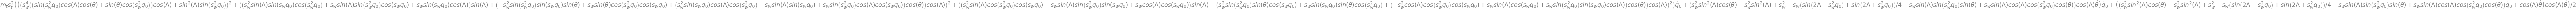

In [128]:
ke

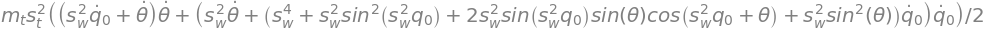

In [127]:
# as with the rest of the model lets assume lambda is zero for now
sym.simplify(ke.subs(p.Lambda,0))

## Need to make some Simplifications

assume Lambda only has the effect to change the distance between the com and the hinge line, and hence can be account for in an augmented distance:

Let $y_{com}$ be the distance from the start of the FWT to the CoM, hence the distance to the com becomes

$\tilde{y}_com = \cos{\Lambda}y_com$

Ignore this would affect the other terms of the inertia matrix (rotational inertias)

as lambda 




